In [100]:
# how to get group's id

import urllib.request 
import json

version = '5.92'
token = '3b4498373b4498373b449837893b2d5a9633b443b44983767eceaa69c02cdeb90d9da85'
group = 'wonderzine'
offsets = [0, 100, 200, 300, 400, 500]

def object_id_getter():   
    req = urllib.request.Request('https://api.vk.com/method/utils.resolveScreenName?screen_name=%s&access_token=%s&v=%s'  % (group, token, version))
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result)
    return data['response']['object_id']

object_id_getter()


54218032

In [101]:
from pymystem3 import Mystem

def lemmatize(thing):
    m = Mystem()
    lemmas = m.lemmatize(thing)
    lemmatized = ''.join(lemmas)
    return lemmatized
#     print(type(lemmatized))
# a = lemmatize('Мы поговорили с директором центра  Надеждой Замотаевой о том, как за это время изменилось отношение к сексуальному насилию за 25 лет работы организации — и как работает центр сегодня')
# print(a)
# lemmatize('Мы поговорили с директором центра  Надеждой Замотаевой о том, как за это время изменилось отношение к сексуальному насилию за 25 лет работы организации — и как работает центр сегодня')

In [ ]:
# database: id - date - weekday- text - lemmatized text -  (months from date), you can also count and add


# + lemmatized texts + wordnumber
import sqlite3
import re
import datetime

def db_posts():
    conn = sqlite3.connect('posts_8.db')
    c = conn.cursor()
    c.execute('CREATE TABLE IF NOT EXISTS posts(post_id integer, date iteger, weekday integer, post_text text, text_lemmatized text, word_number integer)')
    for i in offsets:
        req = urllib.request.Request('https://api.vk.com/method/wall.get?count=30&domain=%s&access_token=%s&v=%s&offset=%s'  % (group, token, version, i))
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result)  
        for item in data['response']['items']:
            post_id = item['id']
            date = datetime.date.fromtimestamp(item['date'])
            weekday = date.weekday()
            text = item['text'] 
            group_mentions = re.sub(' \[.+?\]', '', text)
            links = re.sub('http:\/\/amp\.gs\/.+', '', group_mentions)
            enter = re.sub('\n', '', links)
            text_lemmatized = lemmatize(enter)
            word_number = len(re.findall(r'\w+', enter))
            c.execute('INSERT INTO posts VALUES (?, ?, ?, ?, ?, ?)', (post_id, date, weekday, enter, text_lemmatized, word_number)) 
            conn.commit()    
    conn.close()
    
db_posts()

In [6]:
def stoplistMaker():
    with open('stoplist.txt', 'r', encoding='utf-8') as f:
        stoplist = f.read().split('\n')
        stoplist.append('https')
        stoplist.append('vk')
    return stoplist

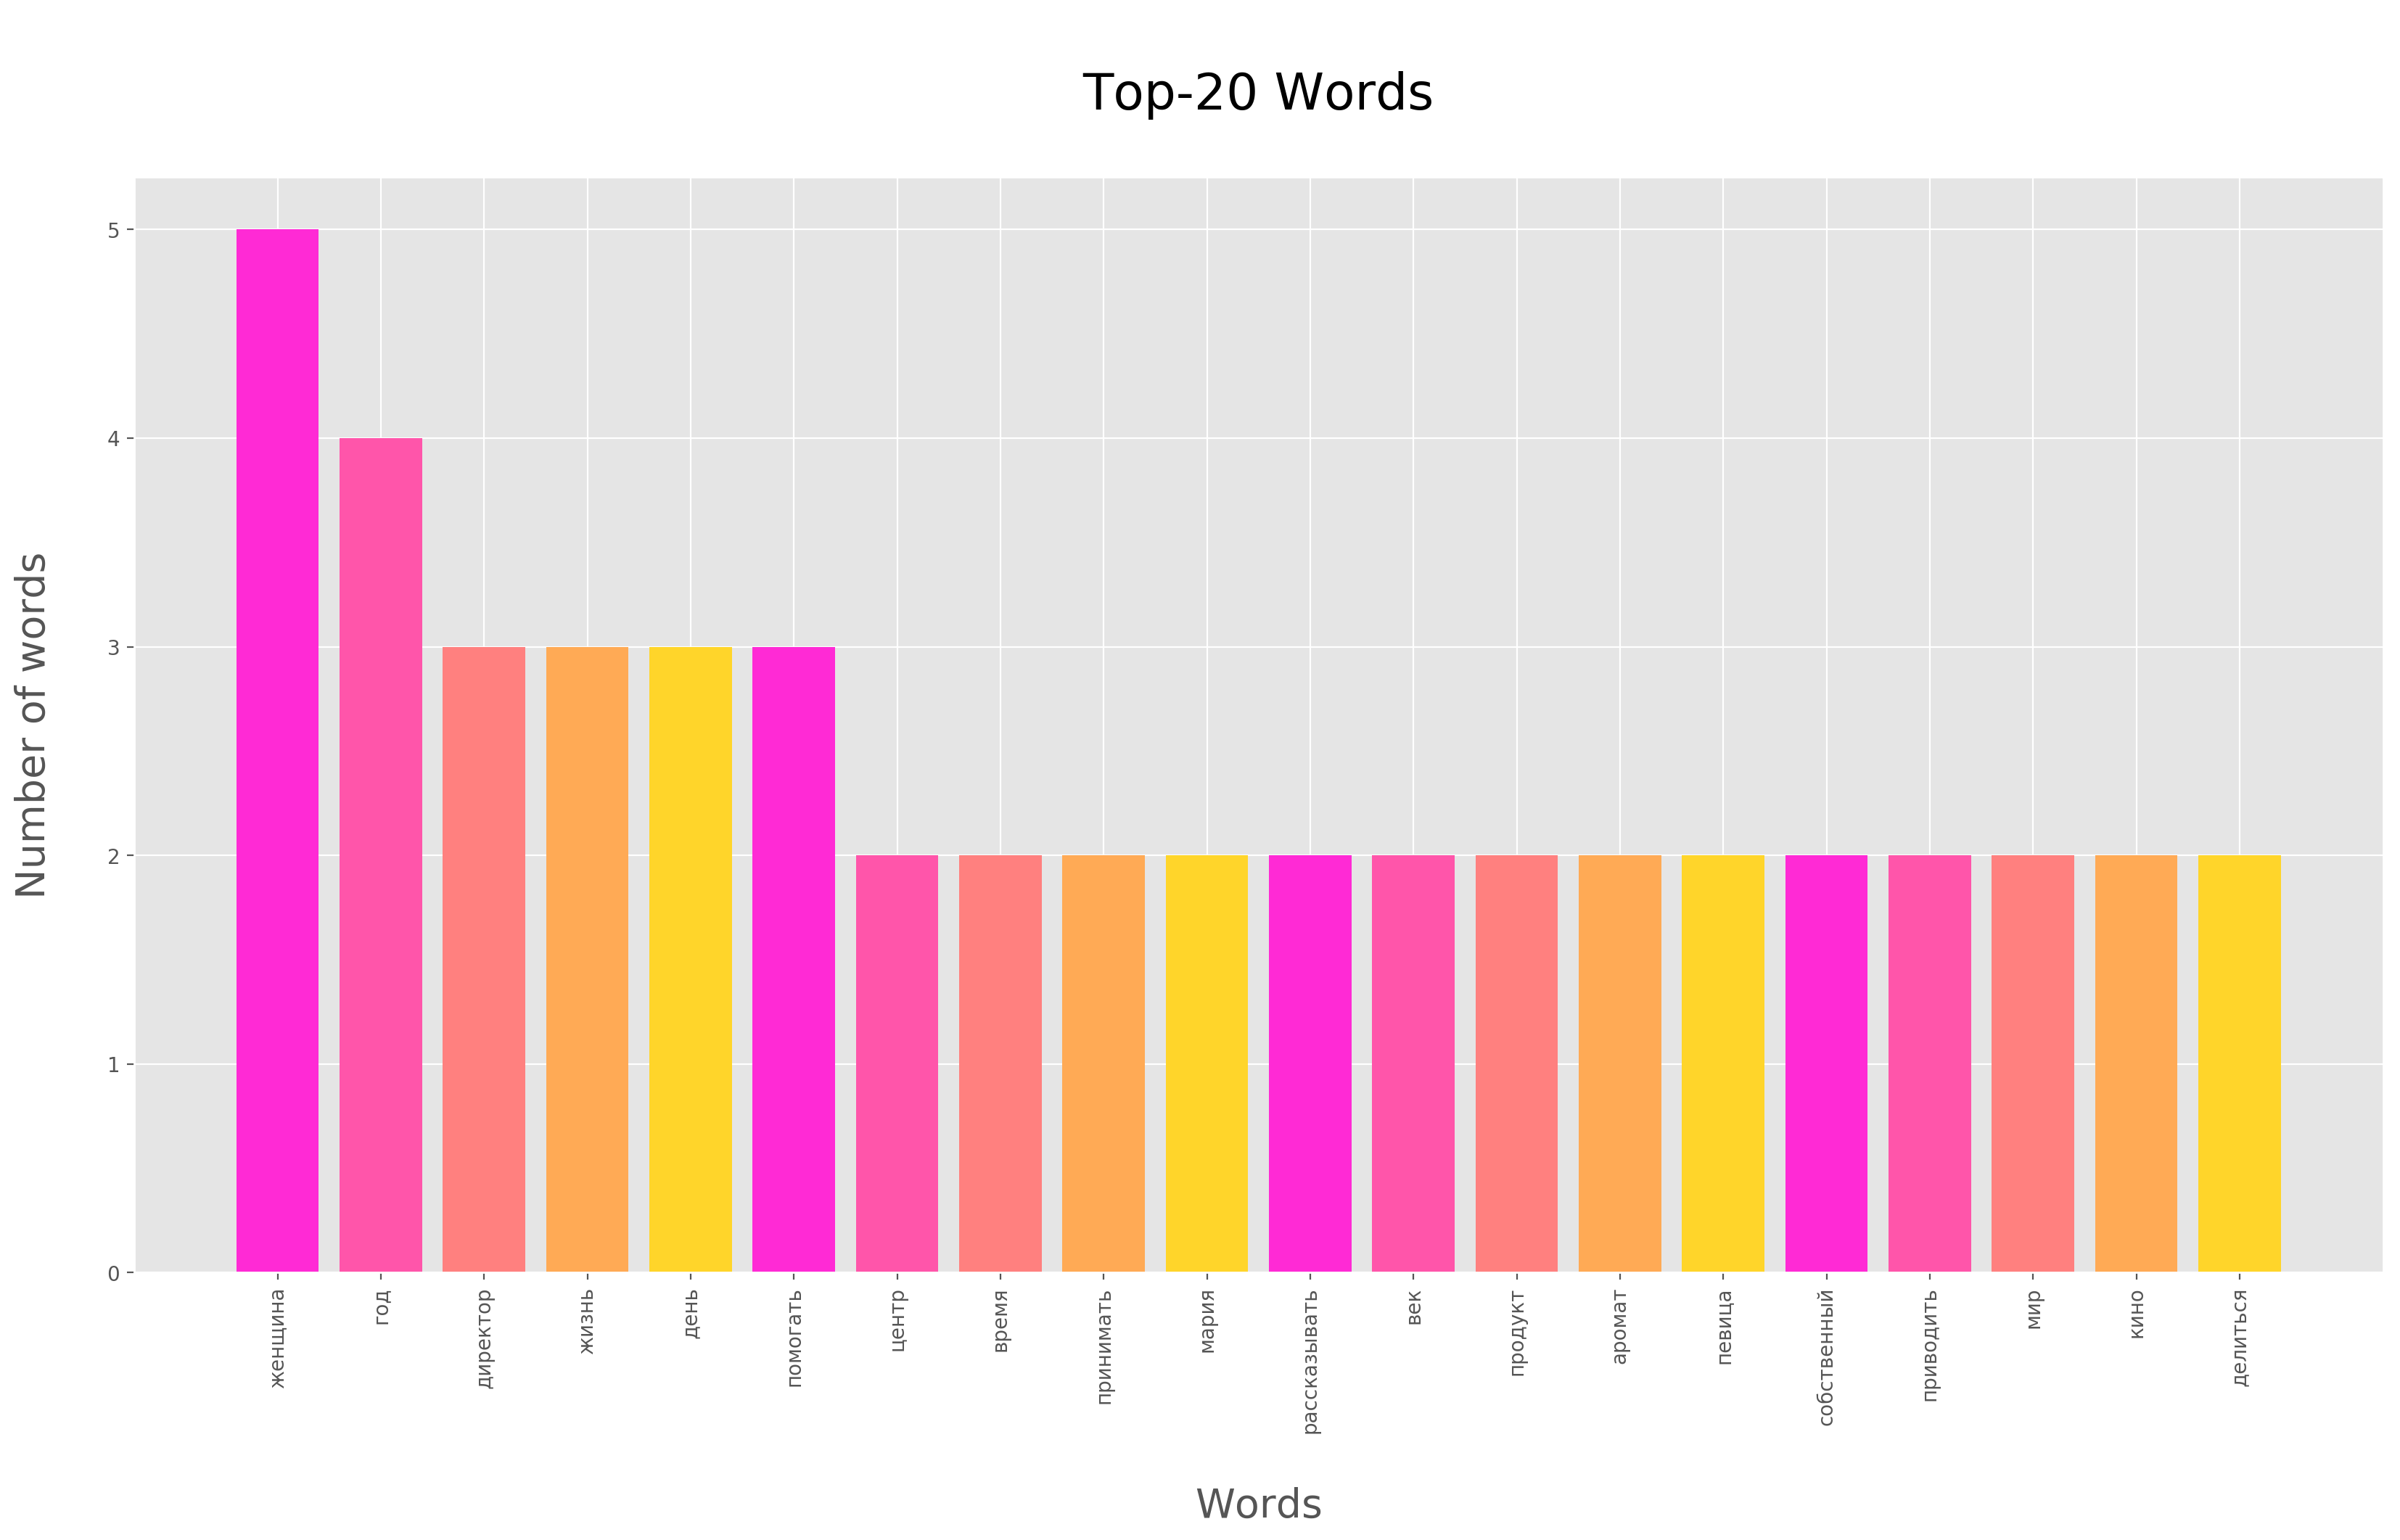

In [14]:
# top-words
# a huge wordlist + -stop-words
import re
import collections
import sqlite3

def top_words(stoplist, text):
#     open the database
    conn = sqlite3.connect('posts+lemm_2.db')
    c = conn.cursor()
#     a huge list of all words from all texts, without stop words
    wordlist = []
    for item in c.execute('SELECT %s FROM posts' %(text)):
        for word in item[0].split():
            w = re.search('\w+', word)
            if w and w.group().lower() not in stoplist:
                wordlist.append(w.group().lower())
    return wordlist


def frequencies(wordlist):
    counter = collections.Counter(wordlist)
    freq_list = sorted(counter.items(), key=lambda x: x[1], reverse=True)
#     for key in sorted(counter, key=counter.get, reverse=True):
#         print(key, counter[key])
    return freq_list


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from heapq import nlargest

def plotMaker(freq_list, pic_name):
    style.use('ggplot')
    X = [word[0] for word in freq_list][:20] # x-labels
    x = range(len(X)) # x-data
    Y = [count[1] for count in freq_list][:20] # y-data
    
    colors = sns.color_palette('spring', max(Y))
    
    plt.figure(figsize=(20, 10), dpi=200)
    plt.bar(x, Y, color=colors)
    
    plt.title('\nTop-20 Words\n', fontsize=25)
    plt.ylabel('Number of words\n', fontsize=20)
    plt.xlabel('\nWords', fontsize=20)
    plt.xticks(x, X, rotation=90)
#     +save pics
    plt.savefig(pic_name + '.png', dpi=100)
    plt.show()
    
#     for a, b in zip(x, Y):
#     if b > 5:
#         plt.scatter(a, b+1.5, s=0)
#         plt.text(a-0.3, b+1.5, str(b))

#     print(top_words)

    
# frequencies(top_words(stoplistMaker()))
plotMaker(frequencies(top_words(stoplistMaker(), 'text_lemmatized')), 'lemmatized')

In [20]:
# database post_id - comment_id - text - length - commentator_id

import sqlite3
import urllib.request 
import json


def db_comments(posts_db_name):  
#     version = '5.92'
#     owner_id = '-' + str(object_id_getter())
#     token = '3b4498373b4498373b449837893b2d5a9633b443b44983767eceaa69c02cdeb90d9da85'
    
    conn = sqlite3.connect(posts_db_name)
    c = conn.cursor()
    post_ids = [item[0] for item in c.execute('SELECT post_id FROM posts')]
    conn.close
    
    conn = sqlite3.connect('comments_2.db')
    c = conn.cursor()
    c.execute('CREATE TABLE IF NOT EXISTS comments(post_id integer, comment_id integer, text text, word_number integer, commentator_id integer)')

    for item in post_ids:
#         print(item)
        req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id=%s&post_id=%s&access_token=%s&v=%s'  % (owner_id, item, token, version))
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result)
#         print(data)
#         return data
        n = data['response']['count']
#         print(n)
        try:
            for i in range (0, n-1):
                comment_id = data['response']['items'][i]['id']
                text = data['response']['items'][i]['text']
                commentator_id = data['response']['items'][i]['from_id']
                word_number = len(re.findall(r'\w+', text))
                c.execute('INSERT INTO comments VALUES (?, ?, ?, ?, ?)', (item, comment_id, text, word_number, commentator_id)) 
                conn.commit()
        except:
            pass            
    conn.close    

db_comments('posts+lemm_2.db')

In [73]:
# post length VS avg comment length
import statistics
# mean(data)
# как итерировать через разные строки в разных таблицах
def postLengthVSavgCommentLength(posts_db_name, comments_db_name):
    posts = {}
#     info = {}
    
    conn = sqlite3.connect(posts_db_name)
    c = conn.cursor()
    c.execute('SELECT post_id, word_number FROM posts')
    a = c.fetchall()
#     post_ids = [item[0] for item in c.execute('SELECT post_id FROM posts')]
# #     conn.close
#     for item in post_ids:
#         posts[item] = info
#     word_number = [num[0] for num in c.execute('SELECT word_number FROM posts')]
# #     for num in word_number:
#         d[key] = num
    
    conn.close
    
    conn = sqlite3.connect(comments_db_name)
    c = conn.cursor()
    c.execute('SELECT post_id, word_number FROM comments')
    b = c.fetchall()
    for item in a: #for every pair of post_id-word_number
        comm_list = []
        for pair in b: #for every pair of post_id for a comment-word_number          
            if item[0] == pair[0]:
                comm_list.append(pair[1])
                posts[item[1]] = int(statistics.mean(comm_list))
    return posts
                
    
#     print(posts)
    
    
postLengthVSavgCommentLength('posts+lemm_2.db', 'comments_2.db')
    

# from scipy.interpolate import interp1d  # это чтобы нарисовать сглаженную кривую
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib import style

# def avgPlot(counter):
#     post_length = [c[1] for c in sorted(counter.items(), key=lambda x: x[0], reverse=False)]
#     print()

{24: 6,
 22: 5,
 35: 5,
 28: 4,
 30: 10,
 7: 3,
 36: 16,
 9: 17,
 23: 6,
 26: 5,
 25: 21,
 34: 10,
 31: 4}

[3, 17, 5, 6, 6, 21, 5, 4, 10, 4, 10, 5, 16] [7, 9, 22, 23, 24, 25, 26, 28, 30, 31, 34, 35, 36]


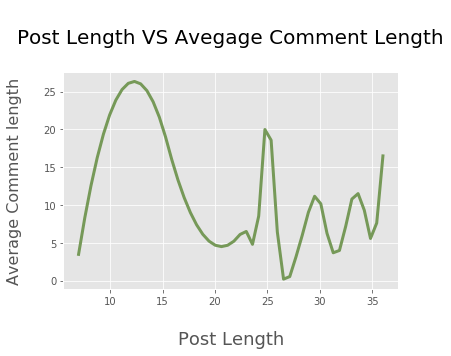

In [97]:
from scipy.interpolate import interp1d  # это чтобы нарисовать сглаженную кривую
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

def avgPlot(counter):
    post_length = [c[1] for c in sorted(counter.items(), key=lambda x: x[0], reverse=False)]
    comment_length = sorted([num for num in counter])
#     print(post_length, comment_length)
    f = interp1d(comment_length, [comment_length+0.5 for comment_length in post_length], kind='quadratic')
    x_new = np.linspace(7, 36) # тут нужны min и max по оси x
    y_smooth = f(x_new)
    plt.plot(x_new, y_smooth, c='xkcd:moss', linewidth='3')
#     print(post_length, comment_length)
    plt.title('\nPost Length VS Avegage Comment Length\n', fontsize=20)
    plt.ylabel('Average Comment length\n',  fontsize=16)
    plt.xlabel('\nPost Length',  fontsize=18)
#     plt.xticks(x, city_labs, rotation=90)
    plt.savefig(pic_name + '.png', dpi=100)
    plt.show()


avgPlot(postLengthVSavgCommentLength('posts+lemm_2.db', 'comments_2.db'))

In [ ]:
# depandency - postlength VS date

In [99]:
# how to make weekdays from numbers
def fromNumberToWeekday(num):
    if num == 0:
        weekday = 'Monday'
    if num == 1:
        weekday = 'Tuesday'
    if num == 2:
        weekday = 'Wednesday'
    if num == 3:
        weekday = 'Thursday'
    if num == 4:
        weekday = 'Friday'
    if num == 5:
        weekday = 'Saturday'
    if num == 6:
        weekday = 'Sunday'    
    return weekday

In [ ]:
# dependency postlength VS weekday


def postLengthVSWeekday(posts_db):
    conn = sqlite3.connect(posts_db_name)
    c = conn.cursor()
    c.execute('SELECT weekday, word_number FROM posts')
    a = c.fetchall()
    weekdays = {}
    nums = []
    for item in a:
        if item[0] not in weekdays.keys():
            nums.append(item[1])
            weekdays[item[0]] = nums
        elif item[0] in weekdays.keys():
            nums.append(item[1])
            
        
    
    

In [69]:
import statistics
a = [18, 2, 9, 61, 6, 1, 0, 44, 4]
print(int(statistics.mean(a)))



16


In [ ]:
import sqlite3
import urllib.request 
import json


# commentator_id - name - followers - city
def db_people():
    version = '5.92'
    token = '3b4498373b4498373b449837893b2d5a9633b443b44983767eceaa69c02cdeb90d9da85'
    
    conn = sqlite3.connect('comments.db')
    c = conn.cursor()
    people_ids = [item[0] for item in c.execute('SELECT DISTINCT commentator_id FROM comments')]
    conn.close
    
    conn = sqlite3.connect('commentators1.db')
    c = conn.cursor()
    c.execute('CREATE TABLE IF NOT EXISTS commentators(commentator_id integer, name text, followers integer, city text)')
    
    for item in people_ids:
        req = urllib.request.Request('https://api.vk.com/method/users.get?user_ids=%s&access_token=%s&v=%s&fields=counters,city'  % (item, token, version))
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result)        
        name = data['response'][0]['first_name'] + ' ' + data['response'][0]['last_name']
        try:
            city = data['response'][0]['city']['title']
        except:
            city = 'None'
        try:
            followers = data['response'][0]['counters']['followers']
        except:
            followers = 'None'
        c.execute('INSERT INTO commentators VALUES (?, ?, ?, ?)', (item, name, followers, city)) 
        conn.commit()
    conn.close


db_people()